In [183]:
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import pickle
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
import statsmodels as sm
import joblib
from scipy.stats import pearsonr

In [176]:
# Load the numpy file with the regression parameters for birth_age

params_path = ('/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation/params_OLS/BirthWeight/STs_right.npy')




In [192]:
def visualize_embeddings_with_regression(
    region="STs_right",
    latent_size=32,
    params_path=params_path, 
    weight2age_path="/neurospin/dico/rmenasria/Runs/01_essai/Program/2023_jlaval_STSbabies/contrastive/notebooks/racim/utilitaire/birth_age_regression_from_weight_model.pkl", 
    ax=None
):
    """

    """

    # Charger labels dHCP
    labels_dHCP = pd.read_csv(
        '/neurospin/dico/rmenasria/Runs/01_essai/Program/2023_jlaval_STSbabies/contrastive/notebooks/racim/all_participants_infos.csv'
    )

    # Chemins
    base_path = (
        "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation_latent_256"
        if latent_size == 256
        else "/neurospin/dico/data/deep_folding/current/models/Champollion_V1_after_ablation"
    )
    region_path = os.path.join(base_path, region)
    subdirs = [d for d in os.listdir(region_path) if os.path.isdir(os.path.join(region_path, d))]
    if len(subdirs) != 1:
        print(f"[AVERTISSEMENT] {region}: {len(subdirs)} sous-dossiers — ignoré.")
        return
    model_folder = subdirs[0]
    baby_path  = os.path.join(region_path, model_folder, "dHCP_random_embeddings",  "full_embeddings.csv")
    adult_path = os.path.join(region_path, model_folder, "ukb40_random_embeddings", "full_embeddings.csv")

    # Lecture embeddings
    baby_embeddings  = pd.read_csv(baby_path,  index_col=0)
    adult_embeddings = pd.read_csv(adult_path, index_col=0)
    baby_embeddings = baby_embeddings.loc[baby_embeddings.index.isin(labels_dHCP['ID'])]
    baby_embeddings = baby_embeddings.join(labels_dHCP.set_index('ID'))


    # Standardisation sur adultes
    scaler     = StandardScaler().fit(adult_embeddings.iloc[:,:latent_size])
    Xs_adults  = scaler.transform(adult_embeddings.iloc[:,:latent_size])
    Xs_babies  = scaler.transform(baby_embeddings.iloc[:,:latent_size])

    # UMAP
    reducer   = umap.UMAP(n_components=2, random_state=42)
    adult_2d  = reducer.fit_transform(Xs_adults)
    baby_2d   = reducer.transform   (Xs_babies)

    # Scores de régression (prédiction d'âge)
    # Xs_babies = sm.add_constant(Xs_babies)
    emb_params = np.load(params_path, allow_pickle=True)
    intercept = emb_params[0]
    weights = emb_params[1:1+latent_size]
    baby_scores = Xs_babies.dot(weights) + intercept

    # MAE poids
    mae_weight = mean_absolute_error(baby_embeddings['birth_weight'], baby_scores)
    r_weight = pearsonr(baby_embeddings['birth_weight'], baby_scores)[0]



    # Age prediction

    # Weight-age(regression dHCP) 
    model = joblib.load(weight2age_path)
    age_pred = model.predict(baby_scores.reshape(-1, 1))
    mae_age  = mean_absolute_error(baby_embeddings['birth_age'], age_pred)
    r_age = pearsonr(baby_embeddings['birth_age'], age_pred)[0]

    

    # Figure comparative
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Projection UMAP 1D
    sc0 = axes[0].scatter(
        baby_embeddings['birth_age'], age_pred,
        c=baby_embeddings['birth_age'], cmap='viridis',
        s=15, edgecolor='k', lw=0.2, alpha=0.8
    )
    axes[0].set_title(f"Prédiction de l'âge après regression\n MAE {mae_age:.2f}, r={r_age:.2f}")
    axes[0].set_xlabel("Âge réel (semaines)")
    axes[0].set_ylabel("Âge prédit (semaines)")
    plt.colorbar(sc0, ax=axes[0], label="Âge réel")

    # Score de prématurité
    sc1 = axes[1].scatter(
        baby_embeddings['birth_weight'], baby_scores,
        c=baby_embeddings['birth_weight'], cmap='coolwarm',
        s=15, edgecolor='k', lw=0.2, alpha=0.8
    )
    axes[1].set_title(f"Poids prédit en fonction du poids réel\n MAE = {mae_weight:.2f}, r={r_weight:.2f}")
    axes[1].set_xlabel("Poids réel (pounds and ounces)")
    axes[1].set_ylabel("Poids prédit")
    # axe y partagé
    plt.colorbar(sc1, ax=axes[1], label="Poids prédit")

    plt.suptitle(f"{region} — Comparaison des projections", y=1.02)
    plt.tight_layout()
    plt.show()

    return axes


/neurospin/dico/rmenasria/Runs/01_essai/Program/env_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/neurospin/dico/rmenasria/Runs/01_essai/Program/env_pixi/.pixi/envs/default/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/neurospin/dico/rmenasria/Runs/01_essai/Program/env_pixi/.pixi/envs/default/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


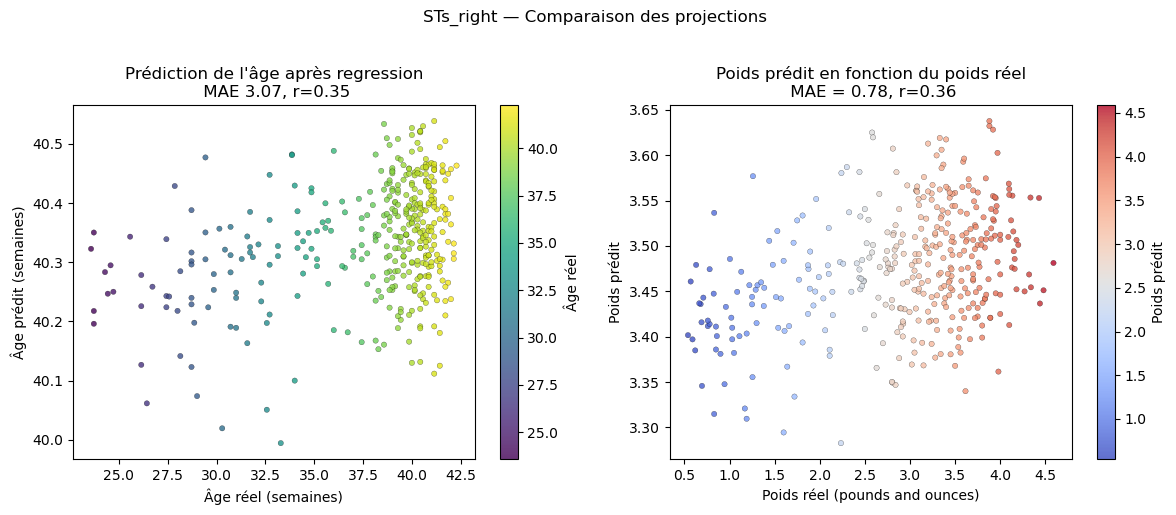

array([<Axes: title={'center': "Prédiction de l'âge après regression\n MAE 3.07, r=0.35"}, xlabel='Âge réel (semaines)', ylabel='Âge prédit (semaines)'>,
       <Axes: title={'center': 'Poids prédit en fonction du poids réel\n MAE = 0.78, r=0.36'}, xlabel='Poids réel (pounds and ounces)', ylabel='Poids prédit'>],
      dtype=object)

In [193]:
# Example usage
visualize_embeddings_with_regression(
    region="STs_right",
    latent_size=32,
    params_path=params_path,
)